# OSSCA : PyTorch Lightning 참가 과제

2. 지원동기 및 제안
3. Basic MNIST Model
4. LitMNIST Model

+ 참고자료 : PyTorch Lightning 공식 MNIST 예제

https://pytorch-lightning.readthedocs.io/en/latest/notebooks/lightning_examples/mnist-hello-world.html

# 지원동기 및 제안

파이토치를 이용하여 석사 논문을 완성하며 신뢰도 높은 결과를 보이려면 파이토치 라이트닝과 같은 라이브러리의 필요성을 절실히 느꼈습니다.
같은 파이토치를 사용하더라도 각자의 코드 스타일로 인해 트레이닝, 테스팅, 로깅, 시각화 등과 같은 기능들이 정리되지 않은 코드들이 많았습니다. 이러한 코드들을 이해하고 재사용하거나 테스트하는 과정에서 시간 낭비를 초래했습니다. 딥러닝 연구개발이 더욱 활성화되고 더 낮은 진입장벽으로 더 훌륭한 아이디어를 발굴하기 위해서 이 같은 문제를 덜어야 한다고 생각합니다.

본 프로젝트에 참여하기 위해 처음 마주한 파이토치 라이트닝은 앞선 문제를 가장 효율적으로 해결하고 있다 생각합니다. 특히 Trainer를 통한 빠르게 테스트할 수 있는 기능, 콜백 함수를 이용한 간단한 추가 기능, 무엇보다 구조화된 딥러닝 학습 등이 과제를 통해 가장 매력적이라 여겼습니다. 

하지만 약간 아쉬운 부분은 다양한 하이퍼파라미터를 이용한 학습 및 테스트가 간단하고 유연하게 작동할 수 있도록 yaml 형식으로 파라미터를 읽어 학습을 할 수 있었으면 합니다. 현재는 모델에서 save_hyperparameters() 함수로 사용된 파라미터들을 checkpoint와 yaml파일을 생성해주고 load시에 이 파일들을 읽어 이전 파라미터들과 학습결과를 그대로 이용할 수 있습니다. 이는 첫 학습시에 적용되지 않으며 처음에는 파라미터들을 일일히 add_argument로 추가해주기 때문에 이 부분의 수고를 덜고 체계적인 파라미터 입력이 있었으면 합니다.

본 프로젝트에 참여하면 위와 같은 간단한 편의기능부터 제안하고 구현해보고 나아가 프로젝트가 끝나더라도 파이토치 라이트닝의 꾸준한 기여자가 되고자 합니다. 현재 오픈소스 프로젝트 참여 경험은 없지만, 딥러닝 연구 경험을 바탕으로 본 프로젝트가 말하는 핵심가치인 One less thing to remember를 지킬 수 있도록 노력하겠습니다.

In [1]:
import os
import pandas as pd
import seaborn as sn
import torch
from IPython.core.display import display
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

/Users/why/opt/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/w4/773thtjx3bb6q09bz3s9j9x80000gn/T/ipykernel_10425/922065957.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


# Basic MNIST Model

- 트레이닝만 하는 간단한 모델
- MNISTModel 클래스는 LightningModule 클래스를 상속하여 Trainer를 사용할 수 있게한다.
- traning_step(batch, batch_idx): 훈련시 매 에폭마다 수행할 기능 추가 (batch : 배치 데이터, batch_idx : 배치 인덱스)
- configure_optimizers() : 훈련시 사용할 최적화함수 리턴

In [11]:
class MNISTModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(28*28, 10)
        
    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [14]:
mnist_model = MNISTModel()

# 데이터로드
train_ds = MNIST(PATH_DATASETS, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE)

# Trainer 인스턴스 생성
#  accelerator: CPU, GPU, TPU, IPU 중 훈련에 사용할 장비 선택, auto : 자동설정, GPU가 존재하면 GPU를 사용
#  devices : 사용할 accelerator 개수
#  max_epochs : 최대 에폭 수
# callbacks : 훈련 중 체크포인트에 도달하여 실행될 콜백 함수 목록, 현재는 TQDMProgressBar로 훈련 진행률 보여줌
trainer = Trainer(
    accelerator="auto",
    devices = 1 if torch.cuda.is_available() else None,
    max_epochs = 3,
    callbacks = [TQDMProgressBar(refresh_rate=20)],
)

# 훈련 실행
trainer.fit(mnist_model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 7.9 K 
--------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:02<00:00, 415.98it/s, loss=0.484, v_num=4]


# LitMNIST Model

- 훈련 모델정의, 훈련, 검증, 테스트, 데이터로드 까지 모두하는 클래스
- traing_step : 기본 모델과 크게 다르지 않다. 입력 데이터 x를 신경망에 입력하여 결과 logit을 얻어 정답 y와 비교하여 loss 계산
- validation_step : 모델을 학습하여 업데이트 하지 않고 검증데이터로 정확도를 측정하는 함수, loss와 acc를 모두 기록한다.
  preds는 검증 데이터를 모델에 입력한 결과이며 이를 정답 y와 비교하여 현재 모델의 accuracy와 loss를 계산한다.
- test_step : 모델 테스트 함수, validation_step과 동일한 기능을 하지만 테스트 데이터는 훈련과 검증단계에서 전혀 사용되지 않은 미지의 데이터이다.
- prepare_data : 사용한 데이터 준비, 현재는 MNIST 데이터의 훈련용과 검증 및 테스트용을 다운로드 받는다.
- setup : 훈련 및 검증 과정인지 테스트 과정인지 stage 파라미터로 구별하여 각 과정에 맞게 데이터를 로드하여 셋팅한다.
- train_dataloader / val_dataloader / test_dataloader : 각각 훈련 / 검증 / 테스트에 사용될 데이터를 PyTorch의 DataLoader 객체에 입력하여 데이터로더를 만든다.

In [16]:
class LitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):
        super().__init__()
        
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        self.num_classes=10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )
        
        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()
    
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
    
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
            
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
            
    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)
    
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)
    
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)
    

In [17]:
model = LitMNIST()

# logger : 훈련 체크포인트 / 하이퍼파라미터 / 검증 및 테스트 손실, 정확도 에폭 번호 테이블이 저장된 metrics.csv 파일 저장
trainer = Trainer(
    accelerator = "auto",
    devices = 1 if torch.cuda.is_available() else None,
    max_epochs =5,
    callbacks = [TQDMProgressBar(refresh_rate=20)],
    logger = CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 55.1 K
1 | val_accuracy  | Accuracy   | 0     
2 | test_accuracy | Accuracy   | 0     
---------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


/Users/why/opt/anaconda3/envs/torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  92%|█████████████████████████████████████████████████████████████████████████▎      | 860/939 [00:03<00:00, 253.65it/s, loss=0.356, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 1:  92%|████████████████████████████████████████████▉    | 860/939 [00:03<00:00, 256.73it/s, loss=0.266, v_num=2, val_loss=0.270, val_acc=0.921]
Validation: 0it [00:00, ?it/s]
Epoch 2:  92%|████████████████████████████████████████████▉    | 860/939 [00:03<00:00, 257.63it/s, loss=0.236, v_num=2, val_loss=0.207, val_acc=0.941]
Validation: 0it [00:00, ?it/s]
Epoch 3:  92%|████████████████████████████████████████████▉    | 860/939 [00:03<00:00, 262.38it/s, loss=0.197, v_num=2, val_loss=0.174, val_acc=0.949]
Validation: 0it [00:00, ?it/s]
Epoch 4:  92%|████████████████████████████████████████████▉    | 860/939 [00:03<00:00, 274.18it/s, loss=0.191, v_num=2, val_loss=0.148, val_acc=0.956]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████████████████████████████████████████████| 939/939 [00:03<00:00, 276

In [18]:
# 저장된 체크포인트로 테스트
trainer.test()

Restoring states from the checkpoint path at logs/lightning_logs/version_2/checkpoints/epoch=4-step=4300.ckpt
Loaded model weights from checkpoint at logs/lightning_logs/version_2/checkpoints/epoch=4-step=4300.ckpt
/Users/why/opt/anaconda3/envs/torch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 326.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9578999876976013
        test_loss           0.13612741231918335
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.13612741231918335, 'test_acc': 0.9578999876976013}]

In [21]:
# 재훈련
trainer.fit(model)


  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 55.1 K
1 | val_accuracy  | Accuracy   | 0     
2 | test_accuracy | Accuracy   | 0     
---------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,0.270251,0.9210,NaN,NaN
1,0.207145,0.9406,NaN,NaN
2,0.174022,0.9492,NaN,NaN
3,0.148001,0.9562,NaN,NaN
4,0.132203,0.9618,NaN,NaN


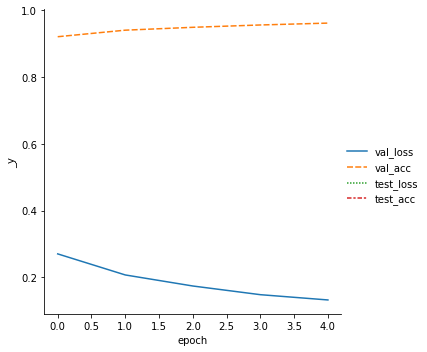

In [22]:
# 시각화 : 저장된 검증 및 테스트 결과인 metrics.csv로 시각화
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")